# Class TemporalGraph

In [2]:
from functools import lru_cache
import os
import json
import networkx as nx
class TemporalGraph:
    def __init__(self, files):
        """
        Initialize TemporalGraph with a list of JSON files representing graphs at different timestamps.
        """
        self.files = files  # List of JSON file paths

    @lru_cache(maxsize=10)  # Cache the last 10 accessed timestamps
    def load_graph_at_timestamp(self, timestamp):
        """
        Load the graph for a specific timestamp from JSON and convert it to a NetworkX graph.
        """
        with open(self.files[timestamp], 'r') as f:
            data = json.load(f)
        return self._json_to_graph(data)

    def _json_to_graph(self, data):
        """
        Convert JSON data to a NetworkX graph.
        """
        graph = nx.DiGraph() if data["directed"] else nx.Graph()
        
        # Add nodes
        
        for node_type, nodes in data["node_values"].items():
            for node in nodes:
                node_id = node[-1]  # Assuming the node ID is the last element in the list
                node_attributes = dict(zip(data["node_types"][node_type], node))
                graph.add_node(node_id, **node_attributes)  # Add the node with its attributes
            
                
        # Add edges
        all_edge_types = data["relationship_types"]

        for i in data["relationship_values"] :
            
            if i[0] in all_edge_types :
                
                attributes = {}
                for j in range(len(i)-2) :
                    key = all_edge_types[i[0]][j]
                    attributes[key] = i[j]

                graph.add_edge(i[-2],i[-1],**attributes)
            else :
                graph.add_edge(i[0],i[1])
    
        
        return graph



# Loading and Wrapper

In [3]:
import time  # Ensure this is imported properly
import tracemalloc
import functools

def time_and_memory(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Start tracking memory and time
        tracemalloc.start()
        start_time = time.time()  # Ensure time module is used correctly
        
        try:
            # Call the actual function
            result = func(*args, **kwargs)
        finally:
            # Calculate memory and time usage
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Print results
            print(f"Time taken by '{func.__name__}': {elapsed_time:.2f} seconds")
            print(f"Memory used by '{func.__name__}': {current / 1024:.2f} KiB (Current), {peak / 1024:.2f} KiB (Peak)")

        return result
    return wrapper

In [5]:
import glob
import re

# Natural sorting function
def natural_sort(files):
    # Extract numeric parts from filenames for sorting
    return sorted(files, key=lambda x: int(re.search(r'timestamp_(\d+)', x).group(1)))

# Get files and sort
files = glob.glob("D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000/timestamp_*.json")
files = natural_sort(files)

# Initialize TemporalGraph
temporal_graph = TemporalGraph(files)
temporal_graph.files

['D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_0.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_1.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_2.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_3.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_4.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_5.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_6.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_7.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_8.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_9.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_10.json',
 'D:/Class Textbook/Sem5/Querying/data/supply_chain_export_1000\\timestamp_

# Queries

### Node Attributes

In [5]:
@time_and_memory
def nodeattr_json(temporal_graph, timestamp, node_id):
    """
    Retrieve node attributes for a given node ID from the JSON data at a specific timestamp.
    """
    with open(temporal_graph.files[timestamp], 'r') as f:
        data = json.load(f)
    
    for node_type, nodes in data["node_values"].items():
        for node in nodes:
            if node[-1] == node_id:
                node_attributes = dict(zip(data["node_types"][node_type], node))
                return node_attributes
    return None  # If node ID is not found

@time_and_memory
def nodeattr_nx(temporal_graph, timestamp, node_id):
    """
    Retrieve node attributes for a given node ID from the NetworkX graph at a specific timestamp.
    """
    graph = temporal_graph.load_graph_at_timestamp(timestamp)
    if node_id in graph:
        return graph.nodes[node_id]
    return None  # If node ID is not found


In [6]:
# Query node attributes using JSON data
node_attributes_json = nodeattr_json(temporal_graph, 1, "BG_001")
print("Node Attributes from JSON:", node_attributes_json)

# Query node attributes using NetworkX graph
node_attributes_nx = nodeattr_nx(temporal_graph, 0, "BG_001")
print("Node Attributes from NetworkX:", node_attributes_nx)


Time taken by 'nodeattr_json': 0.23 seconds
Memory used by 'nodeattr_json': 6.37 KiB (Current), 7093.42 KiB (Peak)
Node Attributes from JSON: {'node_type': 'BusinessGroup', 'name': 'Etch', 'description': 'Etch Business Unit', 'revenue': 7579.889890021863, 'id': 'BG_001'}
Time taken by 'nodeattr_nx': 0.52 seconds
Memory used by 'nodeattr_nx': 6873.95 KiB (Current), 8787.96 KiB (Peak)
Node Attributes from NetworkX: {'node_type': 'BusinessGroup', 'name': 'Etch', 'description': 'Etch Business Unit', 'revenue': 7650.457856762721, 'id': 'BG_001'}


### Edge Attributes

In [15]:
def get_node_and_edge_features(temporal_graph,timestamp, node_id):
    G = temporal_graph.load_graph_at_timestamp(timestamp)
    if node_id in G.nodes:
        edge_features = {edge: G.edges[edge] for edge in G.edges(node_id)}
        return edge_features
    else:
        print("No such node present in graph.")
        return None


In [16]:
edge_features=get_node_and_edge_features(temporal_graph,0,"F_005")
print("Edge features are:",edge_features)

Edge features are: {('F_005', 'P_385'): {'relationship_type': 'FacilityToParts', 'production_cost': 8690.606434327248, 'lead_time': 11.493008107341215, 'quantity': 18}, ('F_005', 'P_372'): {'relationship_type': 'FacilityToParts', 'production_cost': 3230.2944432457257, 'lead_time': 13.522268305956914, 'quantity': 15}, ('F_005', 'P_499'): {'relationship_type': 'FacilityToParts', 'production_cost': 4162.067934222065, 'lead_time': 6.910085256899267, 'quantity': 19}}


### Subgraph

In [16]:
@time_and_memory
def query_ego_graph(temporal_graph,timestamp, node_id, radius=2):
    G = temporal_graph.load_graph_at_timestamp(timestamp)
    ego_graph = nx.ego_graph(G, node_id, radius=radius, undirected=False)
    print(f"Ego Graph for node {node_id}:")
    print(f"Number of nodes: {ego_graph.number_of_nodes()}")
    print(f"Number of edges: {ego_graph.number_of_edges()}")
    return ego_graph

def visualize_ego_graph(ego_graph):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(ego_graph, seed=42)
    nx.draw(ego_graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Ego Graph Visualization")
    plt.show()


Ego Graph for node P_001:
Number of nodes: 49
Number of edges: 50
Time taken by 'query_ego_graph': 0.01 seconds
Memory used by 'query_ego_graph': 50.87 KiB (Current), 56.38 KiB (Peak)


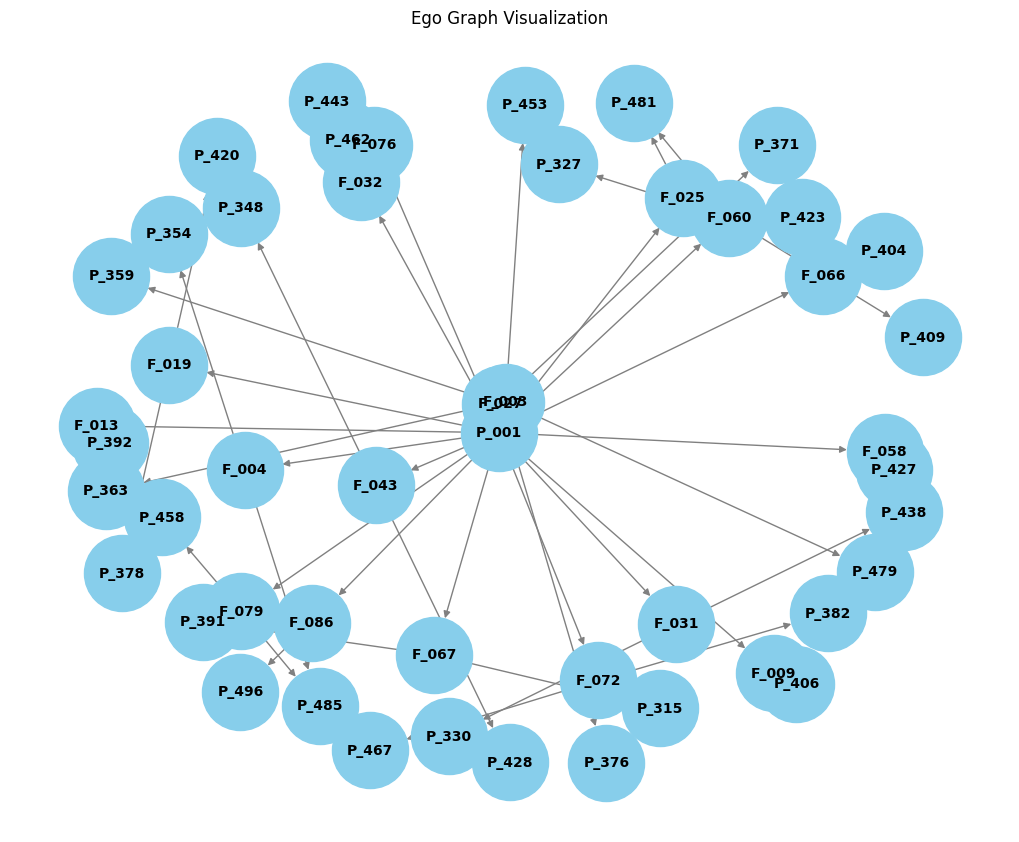

In [17]:
node_id = 'P_001'
radius=2
ego_graph = query_ego_graph(temporal_graph,0, node_id,radius)
visualize_ego_graph(ego_graph)

### Shortest Path

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

@time_and_memory
def shortest_path_query(temporal_graph, timestamp, source, target, weight=None):
    """
    Finds the shortest path between two nodes in the graph at a specific timestamp and plots the path alone.

    Parameters:
        temporal_graph (TemporalGraph): The temporal graph object.
        timestamp (int): The timestamp to retrieve the graph for.
        source (str): The source node ID.
        target (str): The target node ID.
        weight (str): Optional edge attribute to use as weight for a weighted shortest path.

    Returns:
        list: The shortest path as a list of node IDs.
        float: The total cost of the path (if weighted).
    """
    try:
        # Load the graph at the given timestamp
        graph = temporal_graph.load_graph_at_timestamp(timestamp)
        
        # Find the shortest path
        if weight:
            path = nx.shortest_path(graph, source=source, target=target, weight=weight)
            cost = nx.shortest_path_length(graph, source=source, target=target, weight=weight)
        else:
            path = nx.shortest_path(graph, source=source, target=target)
            cost = len(path) - 1  # Unweighted cost is the number of edges
        
        # Plot the shortest path
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph)  # Positioning of the nodes
        
        # Get edges in the path
        path_edges = list(zip(path[:-1], path[1:]))  # Generate edges from the path

        # Draw the nodes and edges of the path
        nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color="lightgreen", node_size=600)
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color="red", width=2)
        nx.draw_networkx_labels(graph, pos, labels={node: node for node in path}, font_size=12, font_weight="bold")
        
        plt.title(f"Shortest Path from {source} to {target}")
        plt.axis("off")  # Turn off the axis for better visualization
        plt.show()

        return path, cost

    except nx.NetworkXNoPath:
        print(f"No path found between {source} and {target}.")
        return None, None
    except nx.NodeNotFound as e:
        print(f"Node not found: {e}")
        return None, None

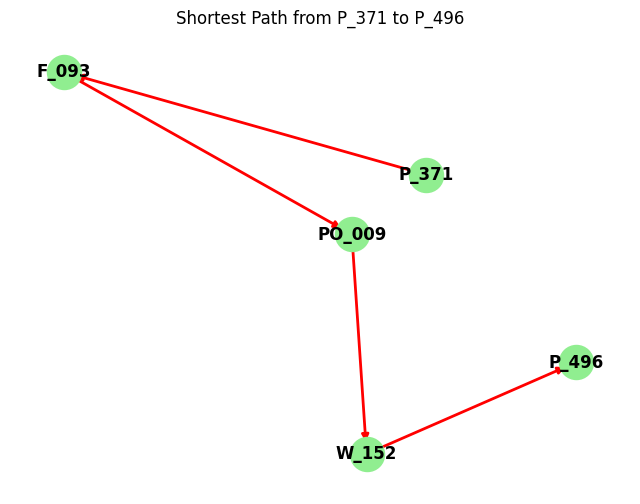

Time taken by 'shortest_path_query': 14.45 seconds
Memory used by 'shortest_path_query': 5864.47 KiB (Current), 7213.68 KiB (Peak)
Shortest path: ['P_371', 'F_093', 'PO_009', 'W_152', 'P_496']
Total cost: 4


In [18]:
path, cost = shortest_path_query(temporal_graph, 0, 'P_371', 'P_496')
print(f"Shortest path: {path}")
print(f"Total cost: {cost}")

### Plotting average of an attribute over timestamps.

In [9]:
import matplotlib.pyplot as plt
@time_and_memory
def track_attribute_over_time(temporal_graph, node_type, attribute):
    """
    Tracks the value of a specified attribute for a given node type across all timestamps
    and plots a graph showing the trend over time.
    
    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        node_type (str): The type of node to track (e.g., "Parts").
        attribute (str): The attribute to track (e.g., "cost").
    """
    # Store timestamp and aggregated attribute values
    timestamps = []
    attribute_values = []
    
    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check if the node type exists in the data
        if node_type in data["node_values"]:
            # Extract attribute values for all nodes of the given type
            values = [
                node[data["node_types"][node_type].index(attribute)]
                for node in data["node_values"][node_type]
                if attribute in data["node_types"][node_type]
            ]
            # Aggregate the attribute values (e.g., average)
            if values:
                timestamps.append(timestamp)  # Use 0-based timestamp indexing
                attribute_values.append(sum(values) / len(values))  # Example: Average value
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, attribute_values, marker='o', linestyle='-', color='b')
    plt.title(f"Trend of '{attribute}' for Node Type '{node_type}' Over Time")
    plt.xlabel("Timestamps")
    plt.ylabel(attribute.capitalize())
    plt.xticks(timestamps)  # Use integer timestamps as x-ticks
    plt.grid()
    plt.tight_layout()
    plt.show()


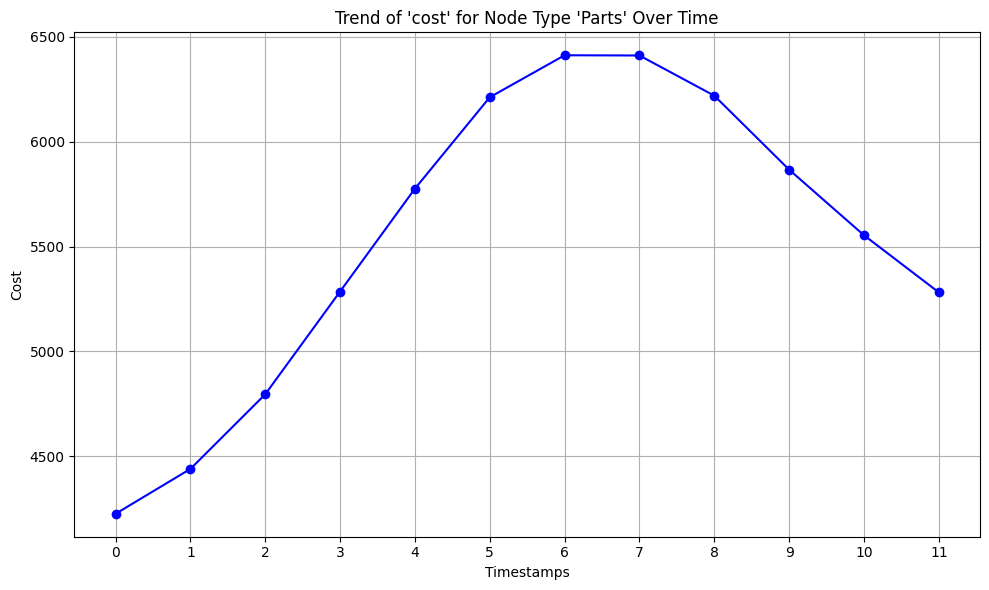

Time taken by 'track_attribute_over_time': 3.28 seconds
Memory used by 'track_attribute_over_time': 1391.29 KiB (Current), 12220.60 KiB (Peak)


In [ ]:
track_attribute_over_time(temporal_graph, node_type="Parts", attribute="revenue")


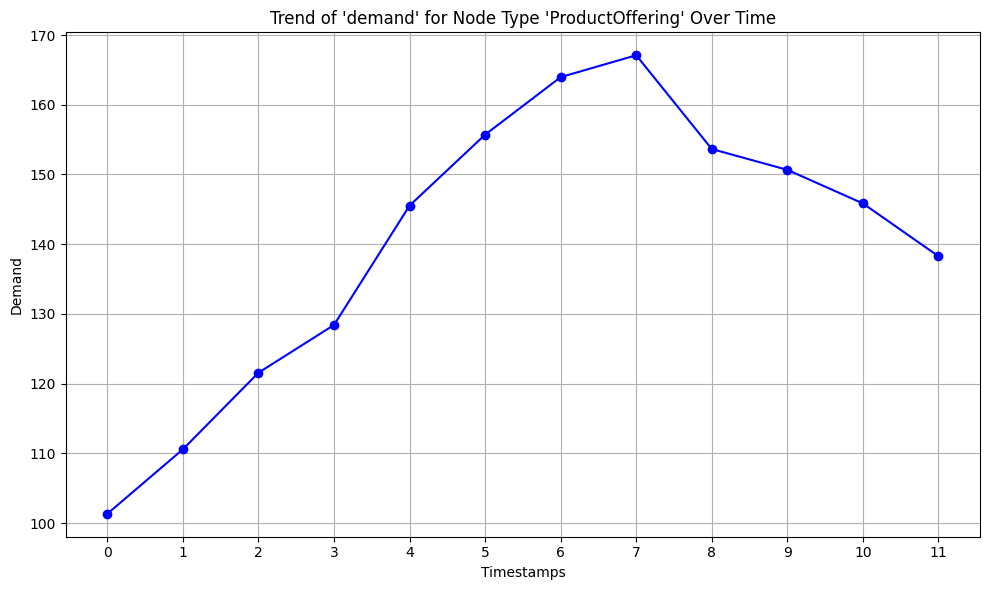

Time taken by 'track_attribute_over_time': 2.66 seconds
Memory used by 'track_attribute_over_time': 912.77 KiB (Current), 12217.15 KiB (Peak)


In [11]:
track_attribute_over_time(temporal_graph, node_type="ProductOffering", attribute="demand")

### Plotting attribute of a Node id over timestamps.

In [12]:
import matplotlib.pyplot as plt

@time_and_memory
def plot_attribute_for_node(temporal_graph, node_id, attribute):
    """
    Plots the value of a specified attribute for a given node ID across all timestamps.
    Raises an error if the attribute is not present in the node.

    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        node_id (str): The ID of the node to track.
        attribute (str): The attribute to track (e.g., "cost").
    """
    # Store timestamp and attribute values
    timestamps = []
    attribute_values = []
    
    # Flag to check if the attribute is present at least once
    attribute_found = False

    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        
        # Check if the node ID exists in the data
        for node_type, nodes in data["node_values"].items():
    
            for subnode in nodes:

                if node_id in subnode:
                    node_index = nodes.index(subnode)
                    node_attributes = data["node_types"][node_type]
                    
                    
                    # Check if the attribute exists for this node type
                    if attribute in node_attributes:
                        attribute_found = True
                        value = data["node_values"][node_type][node_index][node_attributes.index(attribute)]
                        timestamps.append(timestamp)  # Use 1-based timestamp indexing
                        attribute_values.append(value)
                    break  # Exit the loop if the node is found
            

    if not attribute_found:
        raise ValueError(f"Attribute '{attribute}' not found for node ID '{node_id}' in any timestamp.")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, attribute_values, marker='o', linestyle='-', color='g')
    plt.title(f"Trend of '{attribute}' for Node ID '{node_id}' Over Time")
    plt.xlabel("Timestamps")
    plt.ylabel(attribute.capitalize())
    plt.xticks(timestamps)  # Use integer timestamps as x-ticks
    plt.grid()
    plt.tight_layout()
    plt.show()


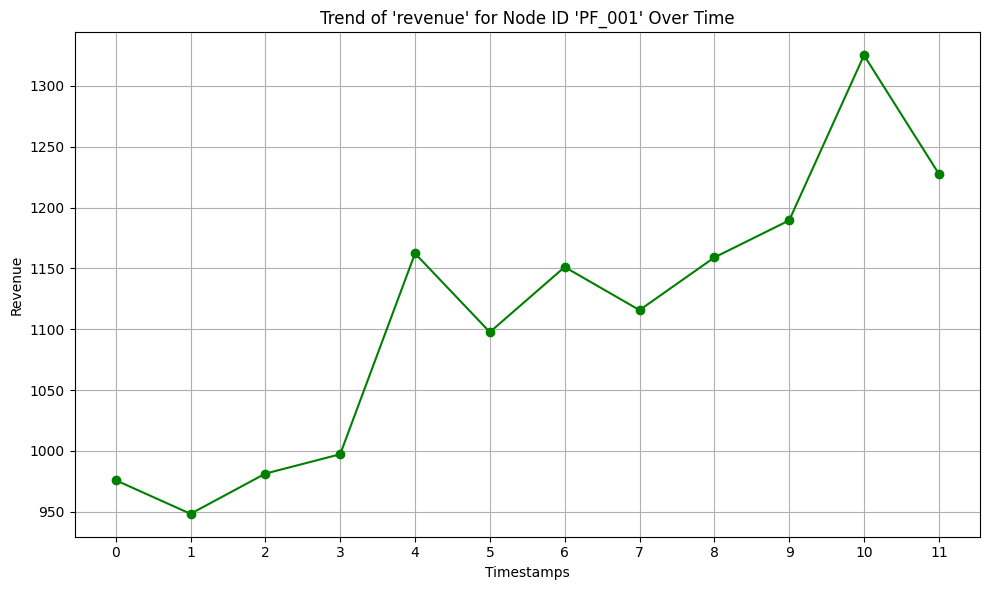

Time taken by 'plot_attribute_for_node': 2.56 seconds
Memory used by 'plot_attribute_for_node': 938.62 KiB (Current), 12217.26 KiB (Peak)


In [13]:
plot_attribute_for_node(temporal_graph, node_id="PF_001", attribute="revenue")

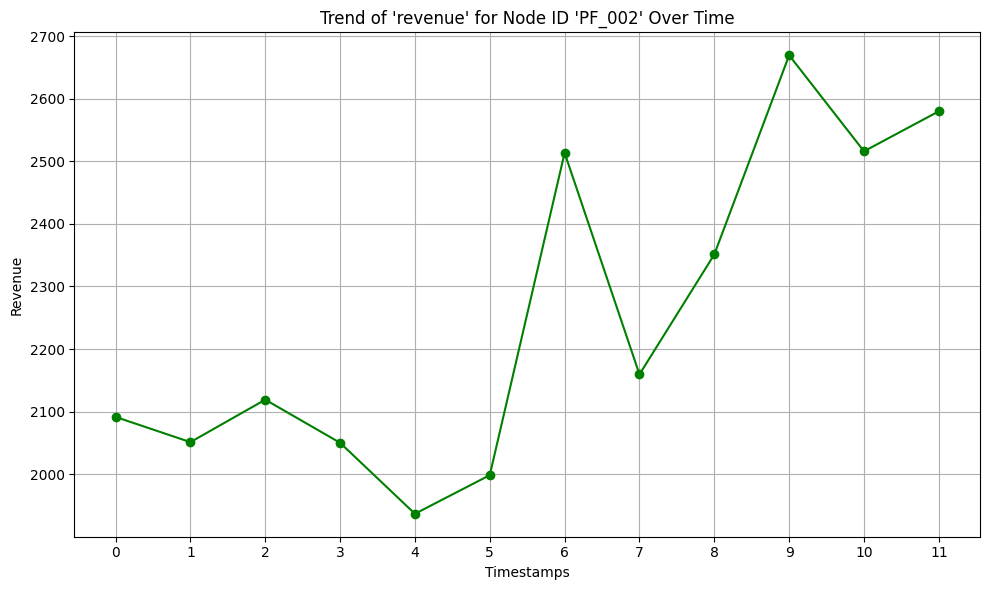

Time taken by 'plot_attribute_for_node': 2.63 seconds
Memory used by 'plot_attribute_for_node': 932.75 KiB (Current), 12216.88 KiB (Peak)


In [14]:
plot_attribute_for_node(temporal_graph, node_id="PF_002", attribute="revenue")

### Ancestor and Decendants

In [6]:
def get_ancestors_descendants(temporal_graph,timestamp, node_id):
    G = temporal_graph.load_graph_at_timestamp(timestamp)
    if node_id in G.nodes:
        return nx.ancestors(G, node_id),nx.descendants(G, node_id)
    
    else:
        print(f"Node {node_id} not found in the graph.")
        return set()


In [9]:
ancestors,descendant = get_ancestors_descendants(temporal_graph,0, "F_005")
print(f"Ancestors: {ancestors}")
print(f"Descendants: {descendant}")

Ancestors: {'S_044', 'W_071', 'S_135', 'W_069', 'S_124', 'S_071', 'W_026', 'W_017', 'S_069', 'S_077', 'W_063', 'S_008', 'S_145', 'W_073', 'P_073', 'S_130', 'W_031', 'S_084', 'S_045', 'S_126', 'P_220', 'W_040', 'S_054', 'P_263', 'P_180', 'P_140', 'S_093', 'S_121', 'S_112', 'S_118', 'P_019', 'S_036', 'S_065', 'W_012', 'S_033', 'S_007', 'S_108', 'S_141', 'S_120', 'S_142', 'S_015', 'W_007', 'S_043', 'S_020', 'S_099', 'S_037', 'S_076', 'S_136', 'P_066', 'W_049', 'S_064', 'W_019', 'W_005', 'W_035', 'W_045', 'W_004', 'P_018', 'P_276', 'W_061', 'S_129', 'S_138', 'P_239', 'P_298', 'P_196', 'S_131', 'P_227', 'W_034', 'S_119', 'W_080', 'S_053', 'W_070', 'S_147', 'W_008', 'S_011', 'S_051', 'P_114', 'W_050', 'S_092', 'S_056', 'W_001', 'S_096', 'S_046', 'W_066', 'P_197', 'S_139', 'S_100', 'S_134', 'S_042', 'S_133', 'S_063', 'S_088', 'S_144', 'S_109', 'S_101', 'S_040', 'S_098', 'S_089', 'W_024', 'S_137', 'S_114', 'S_034', 'S_066', 'W_027', 'S_061', 'W_011', 'W_014', 'P_020', 'P_086', 'S_079', 'S_060'

### Topological Sort

In [10]:
def topological_sort(temporal_graph, timestamp):
    G = temporal_graph.load_graph_at_timestamp(timestamp)
    try:
        return list(nx.topological_sort(G))
    except nx.NetworkXUnfeasible:
        print("The graph is not a Directed Acyclic Graph (DAG) and cannot be topologically sorted.")
        return []

In [11]:
topo_sorted_nodes = topological_sort(temporal_graph, 0)
    
if topo_sorted_nodes:
    print(f"Topologically sorted nodes: {topo_sorted_nodes}")

The graph is not a Directed Acyclic Graph (DAG) and cannot be topologically sorted.


### Next